# MOF Recommender System: Constructing a matrix with Henry coefficients from the Sparsity Matrix

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps

### Load in the Sparsity Matrix and other relevant files

In [2]:
mof_gas_df = pd.read_csv('mof_gas_dataframe.csv')
mof_gas_df.set_index(list(mof_gas_df)[0], inplace=True)
mof_gas_df[mof_gas_df.columns[0:4]][0:4]

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K
Unnamed: 0,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,1


In [3]:
with open('mof_gas_to_filename.json') as infile:
    mof_gas_to_filename = json.load(infile)

### We will need a function to convert the units of the isotherms for consistency's sake

#### First we need to be able to compute the molecular weight of the adsorbates

In [4]:
# Lets start by getting the molecular formula in a dictionary:
url = "https://adsorbents.nist.gov/isodb/api/gas/"

inchikey_to_formula = {}
for inchikey_temp in mof_gas_df.columns:
    inchikey = inchikey_temp.split('_')[0]
    gas_data = json.loads(requests.get(url + inchikey + '.json').content)
    inchikey_to_formula[inchikey] = gas_data['formula']

# Lets also load in the atomic masses of each element:
atomic_masses = pd.read_csv('atomicmasses.csv')

In [5]:
def formula_to_mw(formula):
    # This splits the formula up into elements plus their frequency in the molecule
    start_i = 0
    elements = []
    for end_i, letter in enumerate(formula[1:], start=1):
        if letter.isupper():
            elements.append([start_i, end_i])
            start_i = end_i
    elements.append([start_i, len(formula)])
       
    # This calculates the molecular weight of each type of element
    total_mw = 0
    for element in elements:
        form = formula[element[0]:element[1]]
        for i, letter in enumerate(form):
            if letter.isdigit():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                total_mw = total_mw + element_mw * np.int(form[i:])
                break
            if form.isalpha():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                total_mw = total_mw + element_mw
                break
    return total_mw

In [6]:
def read_and_convert(isotherm_file):
    with open('isotherms/' + isotherm_file + '.json') as infile:
        isotherm_data = json.load(infile)
    # Pressure Units    
    pUnit = isotherm_data['pressureUnits']
    assert pUnit == 'bar'
    
    # Adsorption Units
    aUnit = isotherm_data['adsorptionUnits']
    assert aUnit in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
    
    aConversion = 0.0
    if aUnit == 'mmol/g':
        aConversion = 1.0
    elif aUnit == 'mmol/kg':
        aConversion = 1.0 / 1000.0
    elif aUnit == 'mol/g':
        aConversion = 1000.0
    elif aUnit == 'wt%' or aUnit == 'g/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw
    elif aUnit == 'ml/g' or aUnit == 'cm3(STP)/g':
        aConversion = 1.0 / 22.4
    elif aUnit =='mg/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1.0 / mw
    else:
        print('Something went horribly wrong!')
        print(isotherm_file)
        assert False
    
    adsorption = []
    pressure = []
    for data_point in isotherm_data['isotherm_data']:
        pressure.append(data_point['pressure'])
        adsorption.append(data_point['species_data'][0]['adsorption'] * aConversion)
    return pressure, adsorption

### We will use PyGAPS to compute the Henry Coefficients of the adsorption isotherms. In the case of multiple isotherms per gas-MOF combination, we take the average

In [33]:
henry_matrix = np.empty(mof_gas_df.shape)
henry_matrix.fill(np.nan)
messed_up_isotherms = []
for (i, mof) in enumerate(mof_gas_df.index):
    for (j, gas) in enumerate(mof_gas_df.columns):
        if mof not in mof_gas_to_filename[gas].keys():
            continue
        filenames = mof_gas_to_filename[gas][mof]
        if len(filenames) < 1:
            continue
        henry_coeffs = np.empty(len(filenames))
        henry_coeffs.fill(np.nan)
        
        for (k, filename) in enumerate(filenames):
            #print(filename)
            pressure, adsorption = read_and_convert(filename)
            isotherm = pygaps.PointIsotherm(
                pressure=pressure,
                loading=adsorption,
                material_name='whatever',
                material_batch='whatever',
                t_iso=298,
                adsorbate='gas')
            try:
                henry_coeff = pygaps.initial_henry_slope(isotherm, max_adsrms=0.01, logx=False, verbose=False)
                henry_coeffs[k] = henry_coeff
                #print(filename, ': ', henry_coeffs[k])
            except Exception as e:
                #print(filename)
                #print(e)
                messed_up_isotherms.append(filename)
        if np.isnan(henry_coeffs).sum() != len(henry_coeffs):
            henry_matrix[i, j] = np.nanmean(henry_coeffs)

#### Run this for adsorption isotherm graphs of the files that we were not able to determine a Henry coefficient

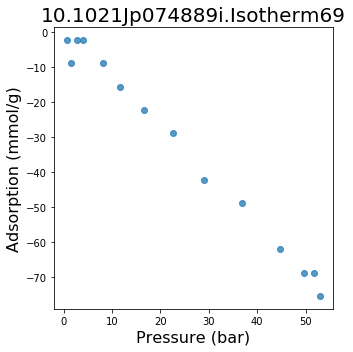

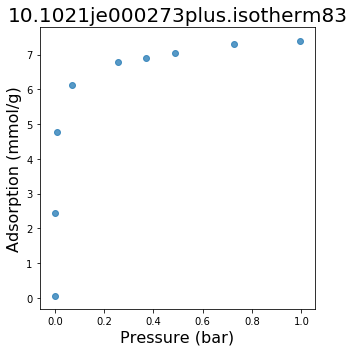

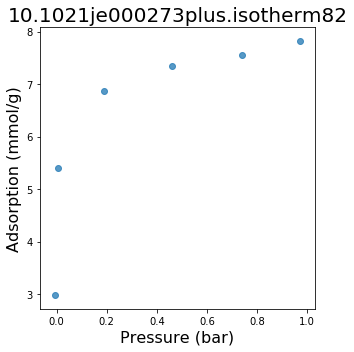

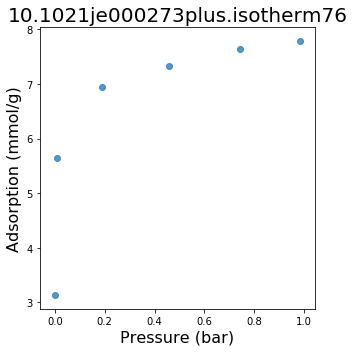

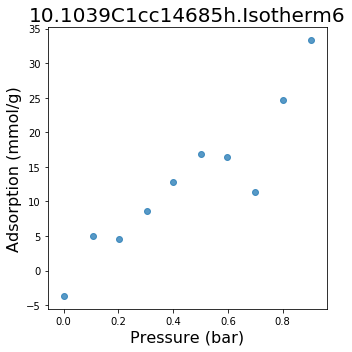

In [34]:
for messed_up_isotherm in messed_up_isotherms[:5]:
    pressure, adsorption = read_and_convert(messed_up_isotherm)
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.scatter(pressure, adsorption, marker='o', alpha=0.75)
    plt.xlabel('Pressure (bar)', fontsize=16)
    plt.ylabel('Adsorption (mmol/g)', fontsize=16)
    plt.title(messed_up_isotherm, fontsize=20)
    plt.tight_layout()
    plt.show()

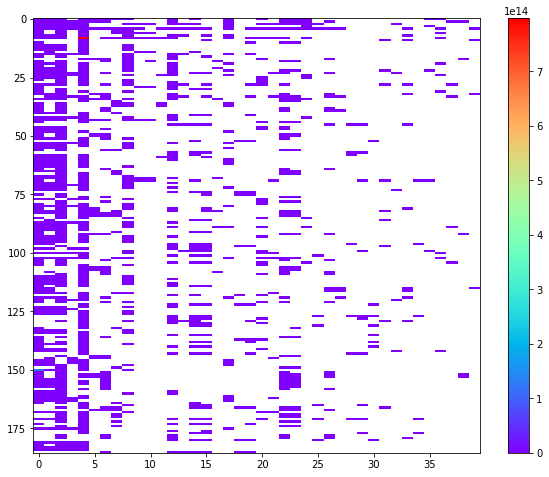

In [35]:
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
plt.imshow(henry_matrix, interpolation='none', cmap='rainbow')
plt.colorbar()
ax.axis('auto')

plt.show()